# **CLASSIFICAZIONE DELLA VARIABILE BINARIA PAID**

In questa sezione ci concentreremo sulla classificazione della variabile binaria PAID utilizzando sia modelli di machine learning classico che tecniche di deep learning. Poiché la variabile PAID è fortemente sbilanciata tra le due classi (PAID=0, minoritaria, e PAID=1, maggioritaria), adotteremo strategie specifiche per mitigare l'impatto di questo squilibrio sulla capacità predittiva del modello. Senza interventi mirati, i modelli tenderebbero a favorire la classe maggioritaria, compromettendo l'efficacia della classificazione.

Per questo motivo, l'accuracy non sarà utilizzata come metrica di valutazione, poiché in un contesto di dati sbilanciati può risultare fuorviante. Ci concentreremo invece su metriche più rappresentative, come il F1-score, la precision, il recall, al fine di ottenere una valutazione più accurata delle prestazioni del modello.

Procediamo all'installazione e all'importazione delle librerie necessarie per l'analisi.

In [1]:
pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 3.3 MB/s eta 0:00:00


In [2]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 30.9 MB/s eta 0:00:00


In [37]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from numpy import mean
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import torch.nn.functional as F
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [21]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
file_path_train = '/content/drive/MyDrive/Recruiting/DataChallenge/processed_df_train_2ndpart.csv'

df_train = pd.read_csv(file_path_train,header=0, engine='python')

print("Prime 5 righe del dataset di train:")
display(df_train.head())

Prime 5 righe del dataset di train:


,N_SUBSCRIPTIONS,PRICE,DAYS_FROM_PROMO,N_TRANSACTIONS,N_ITEMS,SUBSCR_CANC,MARGIN,MONTH,DAYS_BETWEEN_TRANSACTIONS,PAYMENT_TYPE_Coupon,POINT_OF_SALE_MI,PHONE_NUMBER,MAIL,AGE_22–30+,PROP_CONBINI_Medio,POINT_OF_SALE_BO,AGE_15–21,PROP_CONBINI_Alto,PAYMENT_TYPE_Card,PAID
0,1,10.99,1,1.386294,2,0,4.068945,7,111,False,False,0,0,False,False,True,True,False,True,1
1,1,13.30,20,1.098612,4,1,4.163825,9,217,False,False,0,0,False,True,True,True,False,False,1
2,2,18.79,6,0.693147,3,0,3.395898,5,152,False,True,0,0,True,False,False,False,False,True,1
3,0,7.96,1,0.693147,2,0,2.090141,4,0,False,True,0,0,False,False,False,True,False,True,1
4,0,12.00,1,0.693147,3,0,3.395898,6,363,False,False,0,0,False,False,True,True,True,False,1


In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16842 entries, 0 to 16841
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   N_SUBSCRIPTIONS            16842 non-null  int64  
 1   PRICE                      16842 non-null  float64
 2   DAYS_FROM_PROMO            16842 non-null  int64  
 3   N_TRANSACTIONS             16842 non-null  float64
 4   N_ITEMS                    16842 non-null  int64  
 5   SUBSCR_CANC                16842 non-null  int64  
 6   MARGIN                     16842 non-null  float64
 7   MONTH                      16842 non-null  int64  
 8   DAYS_BETWEEN_TRANSACTIONS  16842 non-null  int64  
 9   PAYMENT_TYPE_Coupon        16842 non-null  bool   
 10  POINT_OF_SALE_MI           16842 non-null  bool   
 11  PHONE_NUMBER               16842 non-null  int64  
 12  MAIL                       16842 non-null  int64  
 13  AGE_22–30+                 16842 non-null  boo

La maggior parte delle librerie di machine learning richiede che le variabili siano rappresentate in forma numerica pertanto convertiamo le variabili booleane in variabili binarie 0 e 1 comprensibili dai modelli.

In [24]:
bool_columns = df_train.select_dtypes(include='bool').columns

df_train[bool_columns] = df_train[bool_columns].astype(int)

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16842 entries, 0 to 16841
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   N_SUBSCRIPTIONS            16842 non-null  int64  
 1   PRICE                      16842 non-null  float64
 2   DAYS_FROM_PROMO            16842 non-null  int64  
 3   N_TRANSACTIONS             16842 non-null  float64
 4   N_ITEMS                    16842 non-null  int64  
 5   SUBSCR_CANC                16842 non-null  int64  
 6   MARGIN                     16842 non-null  float64
 7   MONTH                      16842 non-null  int64  
 8   DAYS_BETWEEN_TRANSACTIONS  16842 non-null  int64  
 9   PAYMENT_TYPE_Coupon        16842 non-null  int64  
 10  POINT_OF_SALE_MI           16842 non-null  int64  
 11  PHONE_NUMBER               16842 non-null  int64  
 12  MAIL                       16842 non-null  int64  
 13  AGE_22–30+                 16842 non-null  int

Alcuni modelli di machine learning (ad esempio, SVM, regressione logistica, k-NN e reti neurali) sono sensibili alla scala delle variabili. Variabili con scale diverse possono dominare altre, influenzando negativamente la capacità del modello di imparare correttamente. Anche se per alcuni modelli non è essenziale come quelli basati su alberi (ad esempio, Random Forest o Gradient Boosting che useremo), procediamo comunque alla standardizzazione delle variabili.

Queste variabili rappresentano misurazioni continue o hanno una scala ampia che potrebbe influenzare modelli sensibili alla scala:

- PRICE
- MARGIN
- DAYS_FROM_PROMO
- N_TRANSACTIONS
- DAYS_BETWEEN_TRANSACTIONS


Imposto il seed per la risproducibilità, separo variabili predittive da variabile target e standardizzo le variabili continue.

In [26]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

X = df_train.drop(columns=['PAID'])
y = df_train['PAID']

continuous_columns = ['PRICE', 'MARGIN', 'DAYS_FROM_PROMO', 'N_TRANSACTIONS', 'DAYS_BETWEEN_TRANSACTIONS']
scaler = StandardScaler()
X[continuous_columns] = scaler.fit_transform(X[continuous_columns])

Considerazioni preliminari:
- Le tecniche adottate nel caso di dataset sbilanciati sono diverse. Di seguito abbiamo adottato diverse strategie per cercare di migliorare le metriche e la classificazione del modello.

# APPROCCIO 1
Classificatori utilizzati: Abbiamo impiegato Random Forest e Gradient Boosting (tecniche di ensemble) poiché sono noti per la loro robustezza e capacità di gestire efficacemente dataset con classi sbilanciate. A questi si affiancano modelli più semplici, come la Regressione Logistica e il SVM, che, pur essendo meno complessi, sono stati testati per fornire un confronto diretto con le prestazioni dei modelli di ensemble

Suddivido il dataset in train e test. La stratificazione garantisce che la proporzione tra le classi della variabile target (y) sia mantenuta sia nel training set che nel test set.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Ogni modello viene testato separatamente in due modi, con e senza SMOTE. L'obiettivo principale è aumentare il numero di esempi della classe minoritaria generando nuovi campioni sintetici, anziché semplicemente duplicare quelli esistenti. Inoltre, aggiungo class_weights e scale_pos_weight per attribuire un peso diverso alle classi.

In [44]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

class_weights = {0: len(y_train) / (2 * sum(y_train == 0)),
                 1: len(y_train) / (2 * sum(y_train == 1))}

scale_pos_weight = class_weights[1] / class_weights[0]

models = {
    "Random Forest": RandomForestClassifier(class_weight=class_weights, random_state=42),
    "Logistic Regression": LogisticRegression(class_weight=class_weights, random_state=42, max_iter=10000),
    "SVM": SVC(class_weight="balanced", probability=True, random_state=42),
    "XGBoost": xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42),
    "LightGBM": LGBMClassifier(class_weight=class_weights, random_state=42),
}

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"Model: {type(model).__name__}")
    print(classification_report(y_test, y_pred))
    if y_prob is not None:
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print("-" * 50)

print("### Models WITHOUT SMOTE ###")
for name, model in models.items():
    print(f"Evaluating {name}...")
    evaluate_model(model, X_train, y_train, X_test, y_test)

print("### Models WITH SMOTE ###")
for name, model in models.items():
    print(f"Evaluating {name}...")
    evaluate_model(model, X_train_sm, y_train_sm, X_test, y_test)

### Models WITHOUT SMOTE ###
Evaluating Random Forest...
Model: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.65      0.12      0.20       291
           1       0.92      0.99      0.96      3078

    accuracy                           0.92      3369
   macro avg       0.79      0.56      0.58      3369
weighted avg       0.90      0.92      0.89      3369

ROC-AUC Score: 0.8281
--------------------------------------------------
Evaluating Logistic Regression...
Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.18      0.75      0.30       291
           1       0.97      0.69      0.80      3078

    accuracy                           0.69      3369
   macro avg       0.58      0.72      0.55      3369
weighted avg       0.90      0.69      0.76      3369

ROC-AUC Score: 0.7976
--------------------------------------------------
Evaluating SVM...
Model: SVC
              precision 


L'obiettivo della nostra analisi è garantire una classificazione accurata dei clienti che effettivamente saldano il conto, basandoci sull'osservazione delle esperienze passate dei proprietari dei negozi. È cruciale evitare di classificare erroneamente questi clienti come non paganti, poiché ciò potrebbe compromettere la loro fidelizzazione e causare una perdita economica e di reputazione per il negozio. Allo stesso tempo, vogliamo minimizzare il numero di clienti erroneamente classificati come paganti quando in realtà non lo sono, al fine di ridurre i rischi di mancati incassi.

In questo contesto, la priorità è ridurre al minimo i falsi negativi (clienti paganti classificati come non paganti), cercando un equilibrio con la riduzione dei falsi positivi (clienti non paganti classificati come paganti), così da ottimizzare il bilanciamento tra fedeltà del cliente e redditività.

Di seguito i migliori risultati ottenuti in termini di recall per la classe 0 e di precision e recall per la classe 1.

In [47]:
import pandas as pd

# Dati delle metriche
metrics = [
    {'Model': 'Random Forest (No SMOTE)', 'Precision_0': 0.65, 'Recall_1': 0.99},
    {'Model': 'Logistic Regression (No SMOTE)', 'Precision_0': 0.18, 'Recall_1': 0.69},
    {'Model': 'SVM (No SMOTE)', 'Precision_0': 0.20, 'Recall_1': 0.71},
    {'Model': 'XGBoost (No SMOTE)', 'Precision_0': 0.32, 'Recall_1': 0.88},
    {'Model': 'LightGBM (No SMOTE)', 'Precision_0': 0.31, 'Recall_1': 0.85},
    {'Model': 'Random Forest (SMOTE)', 'Precision_0': 0.33, 'Recall_1': 0.92},
    {'Model': 'Logistic Regression (SMOTE)', 'Precision_0': 0.11, 'Recall_1': 0.25},
    {'Model': 'SVM (SMOTE)', 'Precision_0': 0.21, 'Recall_1': 0.76},
    {'Model': 'XGBoost (SMOTE)', 'Precision_0': 0.23, 'Recall_1': 0.76},
    {'Model': 'LightGBM (SMOTE)', 'Precision_0': 0.20, 'Recall_1': 0.69}
]

df = pd.DataFrame(metrics)

df_sorted = df.sort_values(by=['Precision_0', 'Recall_1'], ascending=[False, False])

top_3_models = df_sorted.head(3)
top_3_models

,Model,Precision_0,Recall_1
0,Random Forest (No SMOTE),0.65,0.99
5,Random Forest (SMOTE),0.33,0.92
3,XGBoost (No SMOTE),0.32,0.88


In [49]:
metrics = [
    {'Model': 'Random Forest (No SMOTE)', 'Precision_1': 0.92, 'Recall_0': 0.12},
    {'Model': 'Logistic Regression (No SMOTE)', 'Precision_1': 0.97, 'Recall_0': 0.75},
    {'Model': 'SVM (No SMOTE)', 'Precision_1': 0.96, 'Recall_0': 0.76},
    {'Model': 'XGBoost (No SMOTE)', 'Precision_1': 0.96, 'Recall_0': 0.62},
    {'Model': 'LightGBM (No SMOTE)', 'Precision_1': 0.97, 'Recall_0': 0.71},
    {'Model': 'Random Forest (SMOTE)', 'Precision_1': 0.94, 'Recall_0': 0.39},
    {'Model': 'Logistic Regression (SMOTE)', 'Precision_1': 0.99, 'Recall_0': 0.97},
    {'Model': 'SVM (SMOTE)', 'Precision_1': 0.96, 'Recall_0': 0.68},
    {'Model': 'XGBoost (SMOTE)', 'Precision_1': 0.97, 'Recall_0': 0.75},
    {'Model': 'LightGBM (SMOTE)', 'Precision_1': 0.97, 'Recall_0': 0.80}
]

df = pd.DataFrame(metrics)

df_sorted = df.sort_values(by=['Recall_0', 'Precision_1'], ascending=[False, False])

df_sorted.head(3)

,Model,Precision_1,Recall_0
6,Logistic Regression (SMOTE),0.99,0.97
9,LightGBM (SMOTE),0.97,0.80
2,SVM (No SMOTE),0.96,0.76


# APPROCCIO 2

Decidiamo di procedere creando un metodo Ensemble utlizzando Random Forest(No SMOTE), XGBoost (No SMOTE), SVM (NO SMOTE) con l'obiettivo di combinare i risultati dei modelli con i migliori risultati.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:47:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.29      0.39       291
           1       0.94      0.98      0.96      3078

    accuracy                           0.92      3369
   macro avg       0.75      0.64      0.67      3369
weighted avg       0.90      0.92      0.91      3369

ROC-AUC Score: 0.8526
Confusion Matrix:
[[  85  206]
 [  64 3014]]


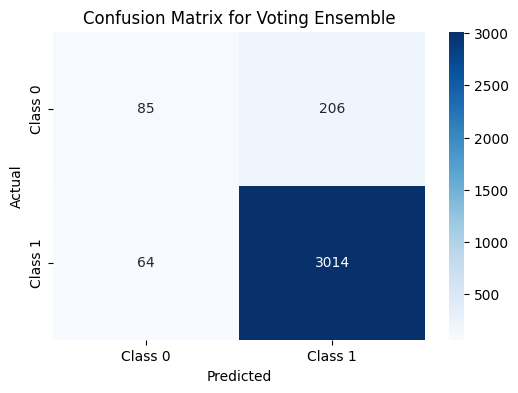

In [56]:
# Suppress LightGBM logs
import os
os.environ['LIGHTGBM_HIDE_OUTPUT'] = '1'

svm_no_smote = SVC(probability=True, random_state=42, class_weight='balanced')
rf_no_smote = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb_no_smote = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')


voting_ensemble = VotingClassifier(
    estimators=[
        ('svm_no_smote', svm_no_smote),
        ('rf_no_smote', rf_no_smote),
        ('xgb_no_smote', xgb_no_smote)
    ],
    voting='hard'
)

voting_ensemble.fit(X_train, y_train)

y_pred = voting_ensemble.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Voting Ensemble")
plt.show()

Dal momento che i risultati precedenti non producono risultati soddifacenti procediamo con la costruzione di una rete neurale.

# RETE NEURALE

Utilizzando i criteri di importanza delle caratteristiche , il metodo individua automaticamente le variabili che contribuiscono maggiormente alla previsione. Ciò ti permette di focalizzarti sulle informazioni più significative.

In [66]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(embeded_rf_feature, 'selected features')
X = X[embeded_rf_feature]

['N_SUBSCRIPTIONS', 'PRICE', 'DAYS_FROM_PROMO', 'N_TRANSACTIONS', 'N_ITEMS', 'MARGIN', 'MONTH', 'DAYS_BETWEEN_TRANSACTIONS', 'PAYMENT_TYPE_Card'] selected features


In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Converto i dati in tensori Pytorch

In [68]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

In [79]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.5)

        self.layer2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)

        self.output_layer = nn.Linear(128, 1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu((self.layer1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.output_layer(x)
        return x

# Calculate class weights
class_counts = y_train.value_counts()
class_weights = {0: len(y_train) / class_counts[0], 1: len(y_train) / class_counts[1]}
weights = [class_weights[int(label)] for label in y_train]

# Initialize the model, loss function and optimizer
input_dim = X_train.shape[1]
model = NeuralNetwork(input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Usa BCELoss con il peso per la classe 0
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights[1]))

# Prepare sampler with a fixed seed
generator = torch.Generator()
generator.manual_seed(42)

sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights), generator=generator)

# Create DataLoader with weighted sampler
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)

# Flag per decidere quali metriche calcolare
use_recall_weighted = False
use_precision_weighted  = True
use_f1_weighted= False

# Valori migliori per le metriche
best_recall = 0.0
best_precision = 0.0
best_f1 = 0.0

best_model_path = "best_model.pth"  # File per salvare il modello migliore

# Ciclo di addestramento
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []  # Predizioni per l'epoca
    all_labels = []  # Etichette reali per l'epoca

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass e ottimizzazione
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Converti i logit in probabilità e poi in predizioni binarie
        probs = torch.sigmoid(outputs).detach().numpy()
        preds = (probs > 0.5).astype(int).flatten()  # Predizioni binarie
        labels = y_batch.numpy().flatten()  # Etichette reali

        # Raccogli le predizioni e le etichette per l'epoca
        all_preds.extend(preds)
        all_labels.extend(labels)

    # Calcola la loss media per l'epoca
    avg_loss = running_loss / len(train_loader)

    # Calcola la recall weighted
    if use_recall_weighted:
        recall_weighted = recall_score(all_labels, all_preds, average='weighted')
        if recall_weighted > best_recall:
            best_recall = recall_weighted
            torch.save(model.state_dict(), best_model_path)  # Salva il modello
            print(f"Epoch {epoch+1}: New best model saved with weighted recall {best_recall:.4f}")

    # Calcola la precision weighted
    if use_precision_weighted:
        precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        if precision_weighted > best_precision:
            best_precision = precision_weighted
            torch.save(model.state_dict(), best_model_path)  # Salva il modello
            print(f"Epoch {epoch+1}: New best model saved with weighted precision {best_precision:.4f}")

    # Calcola l'F1-score weighted
    if use_f1_weighted:
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')
        if f1_weighted > best_f1:
            best_f1 = f1_weighted
            torch.save(model.state_dict(), best_model_path)  # Salva il modello
            print(f"Epoch {epoch+1}: New best model saved with weighted F1-score {best_f1:.4f}")

Epoch 1: New best model saved with weighted precision 0.6516
Epoch 2: New best model saved with weighted precision 0.6932
Epoch 3: New best model saved with weighted precision 0.7002
Epoch 4: New best model saved with weighted precision 0.7039
Epoch 5: New best model saved with weighted precision 0.7158
Epoch 7: New best model saved with weighted precision 0.7215
Epoch 8: New best model saved with weighted precision 0.7227
Epoch 9: New best model saved with weighted precision 0.7323
Epoch 10: New best model saved with weighted precision 0.7338
Epoch 12: New best model saved with weighted precision 0.7360
Epoch 13: New best model saved with weighted precision 0.7457
Epoch 17: New best model saved with weighted precision 0.7515
Epoch 22: New best model saved with weighted precision 0.7521
Epoch 24: New best model saved with weighted precision 0.7562
Epoch 27: New best model saved with weighted precision 0.7566
Epoch 28: New best model saved with weighted precision 0.7638
Epoch 33: New be

In [92]:
# Carica i pesi salvati
model.load_state_dict(torch.load("best_model.pth"))

# Imposta il modello in modalità di valutazione
model.eval()
# Converti i dati di test in tensori PyTorch
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)  # Se necessario

# Predict probabilities using Sigmoid
model.eval()
with torch.no_grad():
    y_test_pred_logits = model(X_test_tensor)  # Raw logits from the model
    y_test_pred_probs = F.sigmoid(y_test_pred_logits).numpy()  # Convert logits to probabilities
    print(y_test_pred_probs)

# Convert probabilities to binary predictions
y_test_pred_binary = (y_test_pred_probs > 0.5).astype(int)

# Calculate and print classification report
report = classification_report(y_test, y_test_pred_binary, target_names=['Class 0', 'Class 1'])
print(report)

[[0.3675693 ]
 [1.        ]
 [0.73012507]
 ...
 [0.83434623]
 [0.85541916]
 [0.13600108]]
              precision    recall  f1-score   support

     Class 0       0.20      0.70      0.31       291
     Class 1       0.96      0.74      0.84      3078

    accuracy                           0.73      3369
   macro avg       0.58      0.72      0.57      3369
weighted avg       0.90      0.73      0.79      3369



<ipython-input-92-a930d7c629ef>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


In [93]:
cm=confusion_matrix(y_test, y_test_pred_binary)

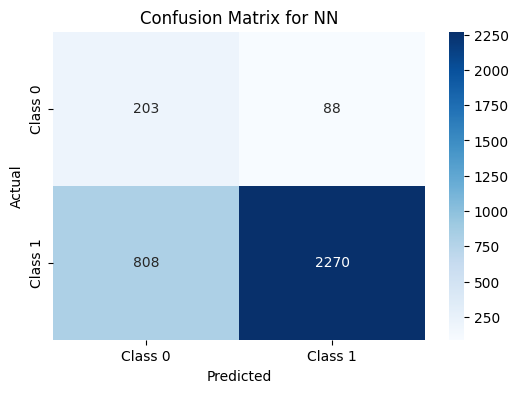

In [94]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for NN")
plt.show()

Confronto Specifico sui Falsi Negativi (Classe 1):
- Neural Network (NN):
Falsi negativi: 808 su un totale di 3078 per la Classe 1. Percentuale di falsi negativi: 26.3%.
- Voting Ensemble:
Falsi negativi: 64 su un totale di 3078 per la Classe 1. Percentuale di falsi negativi: 2.1%.

Se l'obiettivo principale per l'azienda è quello di minimizzare i falsi negativi, allora il modello basato su Voting Ensemble rappresenta una scelta appropriata, in quanto classifica un numero significativamente inferiore di clienti paganti come non paganti (solo il 2.1% di falsi negativi). Tuttavia, questo modello presenta una limitazione importante: il numero di veri negativi (clienti non paganti correttamente classificati) è meno della metà di quelli realmente esistenti, suggerendo una capacità limitata nel rilevare i clienti non paganti.

D'altra parte, il secondo metodo (Neural Network) presenta un numero maggiore di falsi negativi, pari al 26% del totale dei clienti paganti, ma riesce a identificare correttamente quasi 2/3 dei clienti non paganti (veri negativi). In un'ottica iniziale di rilevazione dei clienti non paganti come priorità aziendale, il secondo metodo potrebbe essere preferibile, in quanto offre una maggiore capacità di classificare correttamente questa classe critica.

Tuttavia, sarebbe opportuno valutare se la percentuale di clienti paganti persi (falsi negativi) con questo modello sia accettabile per l'azienda. Qualora questa percentuale risulti sufficientemente bassa, il secondo metodo potrebbe rappresentare un compromesso adeguato tra l'identificazione dei clienti non paganti e il mantenimento della fidelizzazione dei clienti paganti.

Basandoci sul miglior modello, procediamo all'imputazione.

Carico il dataset di test

In [108]:
file_path = "/content/drive/MyDrive/Recruiting/DataChallenge/processed_df_test_2ndpart.csv"
df_test = pd.read_csv(file_path)

event_ids = df_test['EVENT_ID']  # Salva EVENT_ID separatamente

Rendo binarie le variabili booleane

In [109]:
bool_columns = df_test.select_dtypes(include='bool').columns

df_test[bool_columns] = df_test[bool_columns].astype(int)

Riscalo le variabili continue

In [110]:
continuous_columns = ['PRICE', 'MARGIN', 'DAYS_FROM_PROMO', 'N_TRANSACTIONS', 'DAYS_BETWEEN_TRANSACTIONS']
scaler = StandardScaler()
df_test[continuous_columns] = scaler.fit_transform(df_test[continuous_columns])

Seleziono solo le variabili che sono state selezionate tramite il train

In [111]:
train_columns = list(X_train.columns)
train_columns

['N_SUBSCRIPTIONS',
 'PRICE',
 'DAYS_FROM_PROMO',
 'N_TRANSACTIONS',
 'N_ITEMS',
 'MARGIN',
 'MONTH',
 'DAYS_BETWEEN_TRANSACTIONS',
 'PAYMENT_TYPE_Card']

In [112]:
X_test = df_test[train_columns]
X_test

,N_SUBSCRIPTIONS,PRICE,DAYS_FROM_PROMO,N_TRANSACTIONS,N_ITEMS,MARGIN,MONTH,DAYS_BETWEEN_TRANSACTIONS,PAYMENT_TYPE_Card
0,2,-0.494312,-1.419448,0.573763,4,0.967330,12,0.125773,1
1,0,-1.422785,0.240097,-0.752442,2,-1.522850,12,-0.687982,0
2,1,-0.698891,-1.224207,-0.752442,2,-1.085228,11,-0.687982,0
3,0,-0.100891,-0.443245,1.644480,1,0.642495,11,0.031273,0
4,1,-1.265417,0.337717,0.573763,3,0.731956,11,0.498526,1
...,...,...,...,...,...,...,...,...,...
3316,0,-0.286586,1.216300,-0.752442,2,-1.411704,11,-0.687982,0
3317,1,-0.802754,1.509161,0.023338,3,-0.027631,12,-0.057978,1
3318,0,0.213846,-1.224207,-0.752442,2,-1.270506,12,-0.687982,1
3319,1,-0.286586,0.825819,-0.752442,1,-0.921948,12,-0.687982,1


In [113]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   N_SUBSCRIPTIONS            3321 non-null   int64  
 1   PRICE                      3321 non-null   float64
 2   DAYS_FROM_PROMO            3321 non-null   float64
 3   N_TRANSACTIONS             3321 non-null   float64
 4   N_ITEMS                    3321 non-null   int64  
 5   MARGIN                     3321 non-null   float64
 6   MONTH                      3321 non-null   int64  
 7   DAYS_BETWEEN_TRANSACTIONS  3321 non-null   float64
 8   PAYMENT_TYPE_Card          3321 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 233.6 KB


In [114]:
X_test = X_test.select_dtypes(include=['number']).fillna(0)


X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)


model.load_state_dict(torch.load("best_model.pth"))

model.eval()

with torch.no_grad():
    y_test_pred_logits = model(X_test_tensor)
    y_test_pred_probs = F.sigmoid(y_test_pred_logits).numpy()


y_test_pred_binary = (y_test_pred_probs > 0.5).astype(int)


df_output = pd.DataFrame({
    'EVENT_ID': event_ids,
    'PREDICTED': y_test_pred_binary.flatten()  # Predizioni binarie
})

output_path = "/content/drive/MyDrive/Recruiting/DataChallenge/test_dataset_predictions.csv"
df_output.to_csv(output_path, index=False)
print(f"Risultati salvati in: {output_path}")


Risultati salvati in: /content/drive/MyDrive/Recruiting/DataChallenge/test_dataset_predictions.csv


<ipython-input-114-b9530121f4e7>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
